In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players<-read_csv("data/players.csv")

sessions<-read_csv("data/sessions.csv")|>
    separate(start_time,into=c("start_date","start_time"),sep=" ")|>
    separate(end_time,into=c("end_date","end_time"),sep=" ")|>
        mutate(
            start_dt = as.POSIXct(paste(start_date,start_time),format="%d/%m/%Y %H:%M"),
            end_dt = as.POSIXct(paste(end_date,end_time),format="%d/%m/%Y %H:%M"),
            duration_mins = as.numeric(difftime(end_dt,start_dt,units="mins"))
        )



Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
player_sessions<-sessions|>
    group_by(hashedEmail) |>
    summarise(
    total_minutes = sum(duration_mins, na.rm = TRUE),
    session_count = n()
    )





In [4]:
full_data<-players|>
    left_join(player_sessions,by="hashedEmail")
head(full_data)


experience,subscribe,hashedEmail,played_hours,name,gender,Age,total_minutes,session_count
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2019,27
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,255,3
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,5,1
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,50,1
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,9,1
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


In [5]:
summary(sessions$duration_mins)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   3.00    9.00   30.00   50.86   73.00  259.00       2 

In [6]:
players|>
    summarise(across(where(is.numeric), ~ round(mean(.x, na.rm = TRUE), 2)))


played_hours,Age
<dbl>,<dbl>
5.85,21.14


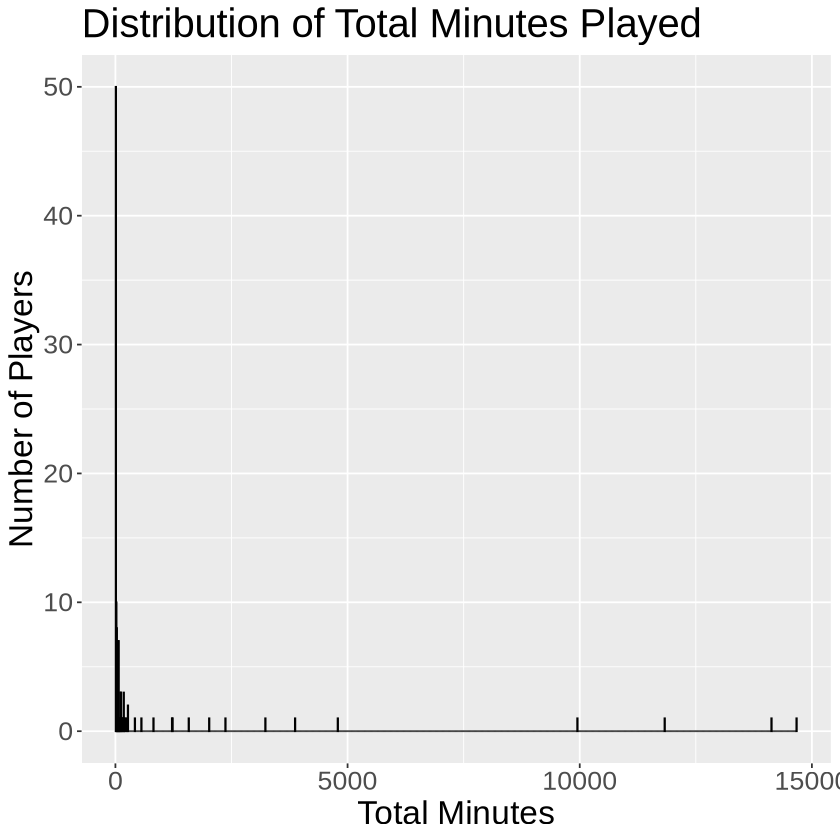

In [11]:
total_mins_histogram<-ggplot(full_data |> filter(!is.na(total_minutes)), aes(x = total_minutes)) +
    geom_histogram(binwidth = 10, fill = "steelblue", color = "black") +
    labs(title = "Distribution of Total Minutes Played",
         x = "Total Minutes",
         y = "Number of Players")+
    theme(text=element_text(size=20))
total_mins_histogram

# The distribution of total minutes played is highly right-skewed. 
#Most players contribute relatively little gameplay data, 
# while a small number of players contribute disproportionately high amounts.
# This suggests that identifying and targeting high-contributing players could,
# and likely would, be impactful for recruitment efforts

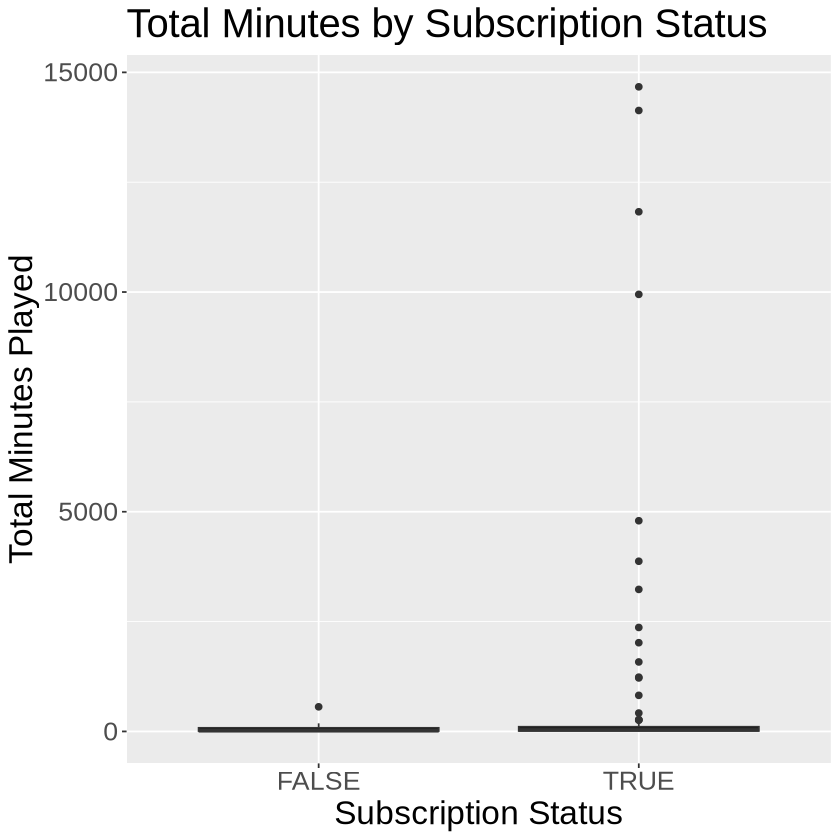

In [12]:
total_mins_boxplot <- ggplot(full_data |> filter(!is.na(total_minutes)), aes(x = subscribe, y = total_minutes)) +
    geom_boxplot(fill = "black") +
    labs(title = "Total Minutes by Subscription Status",
         x = "Subscription Status",
         y = "Total Minutes Played")+
    theme(text=element_text(size=20))
total_mins_boxplot

# subscribers tend to have higher total minutes played compared to non-subscribers
# there is larger clustering of players who have played less time, but significantly more people who are subscribed engage in the game more
# there are is very few time recorded of players who are not subscribed, therefore subscription status is likely a high predictor of gameplay contribution

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


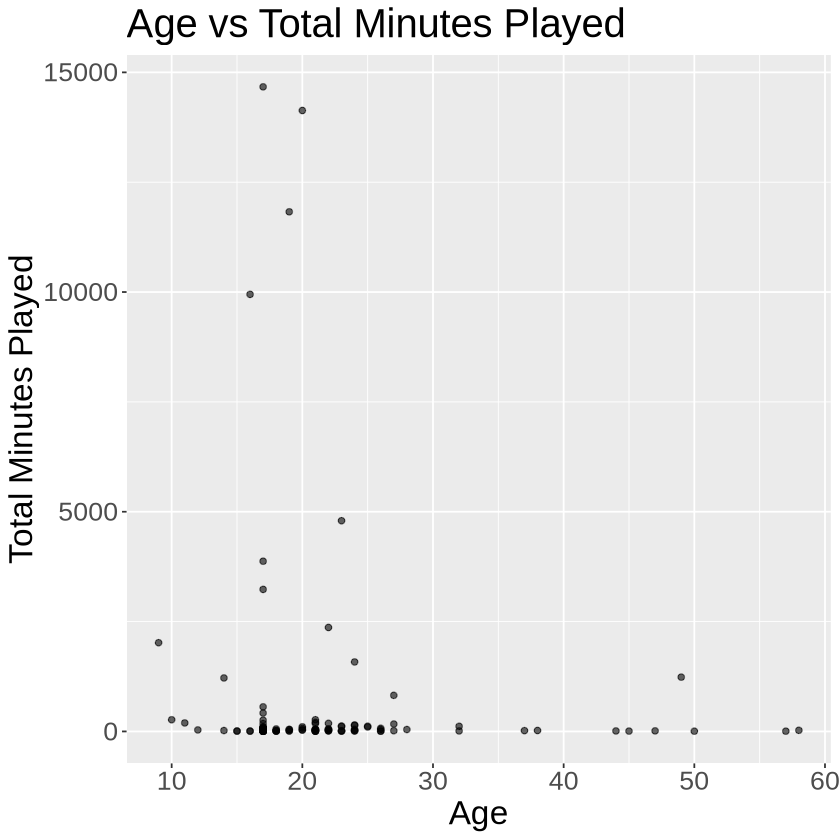

In [15]:
total_mins_scatterplot<-ggplot(full_data |> filter(!is.na(total_minutes)), aes(x = Age, y = total_minutes)) +
  geom_point(alpha = 0.6, color = "black") +
  labs(title = "Age vs Total Minutes Played",
       x = "Age",
       y = "Total Minutes Played")+
    theme(text=element_text(size=20))
total_mins_scatterplot

# most people who game are young adults, teenage to late 20s age. 
# there is no clear linear relationship between age and total minutes, but a few older players seem to be high contributors
# this suggests age may interact with other traits, like experience or subscription status 